In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import edhec_risk_kit as erk

In [2]:
erk.bond_price(5, 100, .05, 12, .03)

0    109.275393
dtype: float64

In [6]:
rates, zc_prices = erk.cir(10, 500, b=.03, r_0 = .03)

In [7]:
erk.bond_price(5, 100, .05, 12, rates.iloc[0][[1,2,3]])

1    109.275393
2    109.275393
3    109.275393
dtype: float64

In [8]:
erk.bond_price(5, 100, .05, 12, rates.iloc[1][[1,2,3]]) 
#theyve started to diverge

1    107.444874
2    110.152004
3    108.039912
dtype: float64

In [10]:
rates[[1,2,3]].head()
#the bonds have started to diverge because the rates have started to diverge
#bond 1 is cheaper because IR has increased, bond 2 is more expensive because IR has decreased

,1,2,3
0,0.030000,0.030000,0.030000
1,0.033796,0.028207,0.032554
2,0.033774,0.026955,0.027820
3,0.031430,0.025952,0.029131
4,0.028986,0.021602,0.028570


<AxesSubplot:>

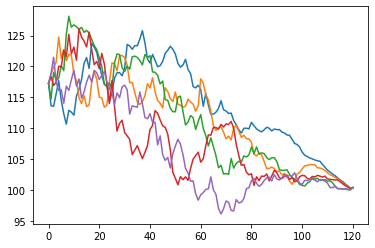

In [14]:
#we changed bond prices in the source kit
erk.bond_price(10, 100, .05, 12, rates[[1,2,3,4,5]]).plot(legend = False)

In [15]:
prices = erk.bond_price(10, 100, .05, 12, rates[[1,2,3,4,5]])
prices

,1,2,3,4,5
0,117.26,117.26,117.26,117.26,117.26
1,113.637,118.833,114.769,118.359,118.935
2,113.561,119.887,119.062,116.924,121.482
3,115.577,120.696,117.694,117.429,117.507
4,117.697,124.755,118.083,120.035,116.116
...,...,...,...,...,...
116,101.395,101.162,100.129,101.031,100.146
117,101.017,100.851,100.22,100.721,100.209
118,100.694,100.571,100.071,100.51,100.179
119,100.35,100.284,100.057,100.241,100.079


In [16]:
br = prices.pct_change().dropna()
erk.annualize_rets(br, 12)
#they are all negative, because this is only looking at the pRICE return
#but the bond also pays a coupon! gotta include that

1   -0.015387
2   -0.015387
3   -0.015387
4   -0.015387
5   -0.015387
dtype: float64

In [17]:
def bond_total_return(monthly_prices, principal, coupon_rate, coupons_per_year):
    """
    Computes the total return of a Bond based on monthly bond prices and coupon payments
    Assumes that dividends (coupons) are paid out at the end of the period (e.g. end of 3 months for quarterly div)
    and that dividends are reinvested in the bond
    """
    coupons = pd.DataFrame(data = 0, index=monthly_prices.index, columns=monthly_prices.columns)
    t_max = monthly_prices.index.max()
    pay_date = np.linspace(12/coupons_per_year, t_max, int(coupons_per_year*t_max/12), dtype=int)
    coupons.iloc[pay_date] = principal*coupon_rate/coupons_per_year
    total_returns = (monthly_prices + coupons)/monthly_prices.shift()-1
    return total_returns.dropna()

In [20]:
p = erk.bond_price(10, 100, .05, 12, rates[[1,2,3,4]])

btr = erk.bond_total_return(p, 100, .05, 12)
erk.annualize_rets(btr, 12)

1    0.028995
2    0.029997
3    0.030057
4    0.031243
dtype: float64

# The total return of the bond is affected by interest rates because the reinvestment into those bonds is affected by the IR at that point in time!

In [25]:
price_10 = erk.bond_price(10, 100, .05, 12, rates)
price_10[[1,2,3]].tail()

,1,2,3
116,101.395,101.162,100.129
117,101.017,100.851,100.22
118,100.694,100.571,100.071
119,100.35,100.284,100.057
120,100.417,100.417,100.417


In [26]:
price_30 = erk.bond_price(30, 100, .05, 12, rates)
price_30[[1,2,3]].tail()
# these prices do not converge! because we are only looking at 10 years of prices for a 30 year bond
# there is still time to mature

,1,2,3
116,178.6,161.24,105.154
117,175.198,159.117,112.136
118,177.415,159.374,105.622
119,178.064,158.753,109.233
120,179.633,161.145,111.073


# Long bonds are not safe! look at how wildly different these returns are! all because of changing interest rates

In [27]:
rets_30 = erk.bond_total_return(price_30, 100, .05, 12)
rets_10 = erk.bond_total_return(price_10, 100, .05, 12)
rets_bonds = .6*rets_10 + .4*rets_30 #assuming we are rebalancing at the same ratio every month

In [28]:
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.035766,0.003549,0.811243,3.269952,-0.001508,-0.001369,1.581139,0.0


In [29]:
#this isn't a great way of doig things, cause averaging out hides things
#see how max drawdown is 0?

In [31]:
price_eq = erk.gbm(n_years=10, n_scenarios=500, mu=.07, sigma = .15)
rets_eq = price_eq.pct_change().dropna()

In [32]:
rets = .7*rets_eq + .3*rets_bonds
rets_mean = rets.mean(axis = 'columns')
erk.summary_stats(pd.DataFrame(rets_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.056872,0.005742,-0.001573,2.72492,-0.001896,-0.001239,4.554564,0.0
